# Plotting Script

## Written by Nils Broman, edited by Jacob Krucinski

In [1]:
import json
import os
import math

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (12,5.5)
plt.rcParams["savefig.facecolor"] = (1,1,1)

In [26]:
dataset_paths = {
    'train': '../corpora/merged_train.txt',
    'dev': '../corpora/merged_dev.txt'
}

In [27]:
train_path = dataset_paths['train']
dev_path = dataset_paths['dev']

model_name = 'merged-10'

input_path = f'../metrics/merged-metrics-eval2.txt'
output_path =  f'merged-figs/'


In [28]:
train_path, dev_path, input_path, output_path

('../corpora/merged_train.txt',
 '../corpora/merged_dev.txt',
 '../metrics/merged-metrics-eval2.txt',
 'merged-figs/')

In [29]:
if not os.path.exists(output_path):
        os.makedirs(output_path)

## Setup
Load config, data etc.

Possible improvement: Instead of saving variables, create a dictionary and kwarg dump in functions to avoid "global-style" variables

In [30]:
def read_data(filename):
  print("File: ", filename)
  with open(filename) as json_file:
    data = json.loads(json_file.read())
  
    return data


In [32]:
data = read_data(input_path)
train_key = train_path.split("/")[-1]
dev_key = dev_path.split("/")[-1]

indices = range(1, len(data['average training loss']) + 1) 

train_data, dev_data, indices, output_dir = data[train_key], data[dev_key], indices, output_path
x = list(indices)

File:  ../metrics/merged-metrics-eval2.txt


## Plotting functions
Plotting functions for loss/accuracy, single metric, scores with multiple averages & confusion matrices

In [33]:
def plot_loss_acc(data, indices, output_dir, train_key, save_to_file = True):  
  x = list(indices)
  plt.xticks(indices)

  plt.plot(x, data['average training loss'],     color="blue")
  plt.plot(x, data['average validation loss'],   color="red")
  plt.plot(x, data[train_key]['accuracy'],     color="green") # accuracies returned by the eval.py script
  plt.plot(x, data['average validation accuracy'], color="orange")

  plt.legend(['avg. training loss', 'avg. validation loss', 
              'avg. training accuracy', 'avg. validation accuracy'], 
              loc="upper center", bbox_to_anchor=(0.5, 1.23),
              fancybox=True, ncol=2)

  plt.xlabel('epoch')
  plt.tight_layout()
  
  if save_to_file: plt.savefig(output_dir + '/training_validation.png')
  plt.show()

In [34]:
def plot_metric(metric, save_to_file = True):
    plt.xticks(indices)

    plt.plot(x, train_data[metric], color="blue")
    plt.plot(x, dev_data[metric], color="red")

    plt.legend(["train", "dev"], loc="upper center", bbox_to_anchor=(0.5, 1.15),
        fancybox=True, ncol=2)

    plt.xlabel('epoch')
    plt.ylabel(metric)

    if save_to_file: plt.savefig(output_dir + '/{}.png'.format(metric))
    plt.show()
    # plt.close()

In [35]:
def plot_score_averages(metric, average_types = False, save_to_file = True):
    if not average_types: average_types = train_data[metric].keys()
    markers = {'macro' : '^', 'micro' : 'v', 'weighted' : 'x'}
    legend_list = []
    
    plt.figure()
    plt.xticks(indices)
    
    for avg_type in average_types:  
        plt.plot(x, train_data[metric][avg_type], marker=markers[avg_type])
        legend_list += [f"train {avg_type}"]
        plt.plot(x, dev_data[metric][avg_type], marker=markers[avg_type])
        legend_list += [f"dev {avg_type}"]
    
    plt.legend(legend_list, loc="upper center", bbox_to_anchor=(0.5, 1.18),
        fancybox=True, ncol=len(average_types))
    plt.xlabel('epoch')
    plt.ylabel(metric)
    
    if save_to_file: plt.savefig(output_dir + '/{}.png'.format(metric), transparent=False)
    plt.show()
    

In [50]:
def plot_confusion_matrices(data, data_name, save_to_file = True, normalize = False):
    ## Adding an option for normalization
    class_list = ["INTERACTOR", "NOT", "PART-OF", "REGULATOR-NEGATIVE", "REGULATOR-POSITIVE"]

    row = math.ceil(math.sqrt(len(x)))
    col = math.floor(math.sqrt(len(x)))
    if row*col<len(x): col+=1

    fig, axs = plt.subplots(row, col, figsize=(5*row,7*col), sharey=True, sharex=True)
    fig.suptitle(f"{data_name} confusion matrices")

    for i in range(len(x)):
        
        cm_df = pd.DataFrame(data["confusion matrices"][i],
                    index = class_list, 
                    columns = class_list)

        if (not normalize):
            g = sns.heatmap(cm_df, annot=True, cmap='Blues', ax=axs.flat[i], cbar=False, fmt='d')
        else:
            cm_df = cm_df.astype('float') / cm_df.sum(axis=1)[:, np.newaxis]
            g = sns.heatmap(cm_df, annot=True, cmap='Blues', ax=axs.flat[i], cbar=False, fmt='.4f')

        g.set_title('Epoch: ' + str(i+1))
        g.set_ylabel('Actal Values')
        g.set_xlabel('Predicted Values')
        g.xaxis.set_label_position('top')
        g.yaxis.set_label_position('right')
    
    # g.yaxis.tick_right()
    if save_to_file and not normalize: 
        plt.savefig(output_dir + '/{}-confusion.png'.format(data_name))
    elif (save_to_file and normalize):
        plt.savefig(output_dir + '/{}-confusion-norm.png'.format(data_name))

    plt.show()
    # plt.close()
    

## Plots

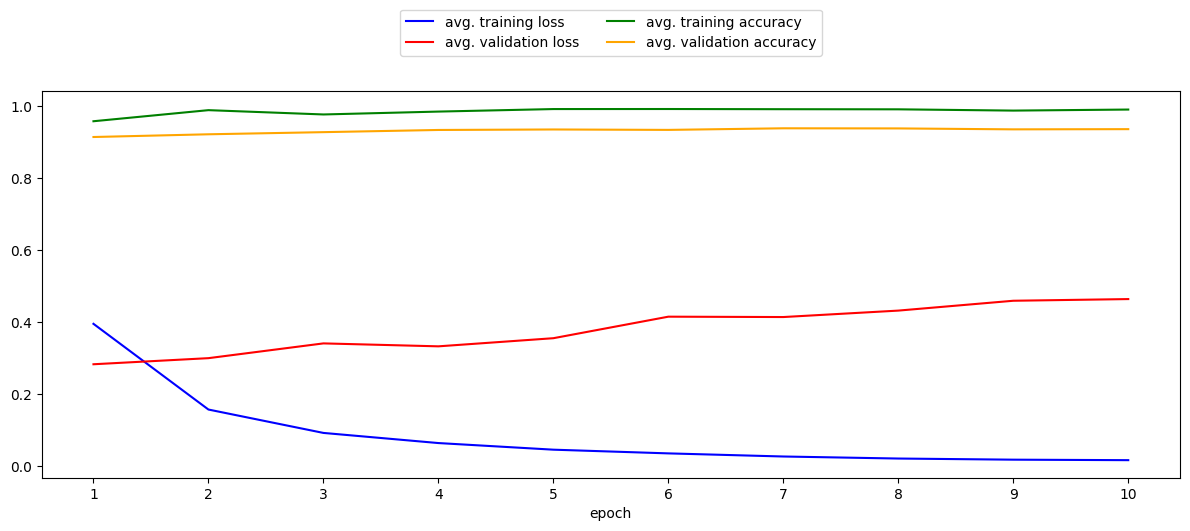

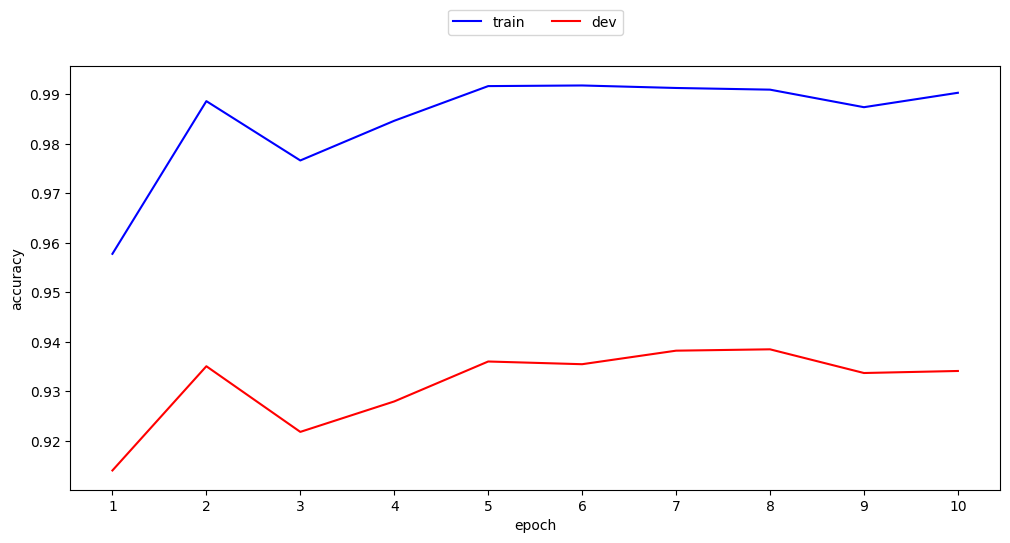

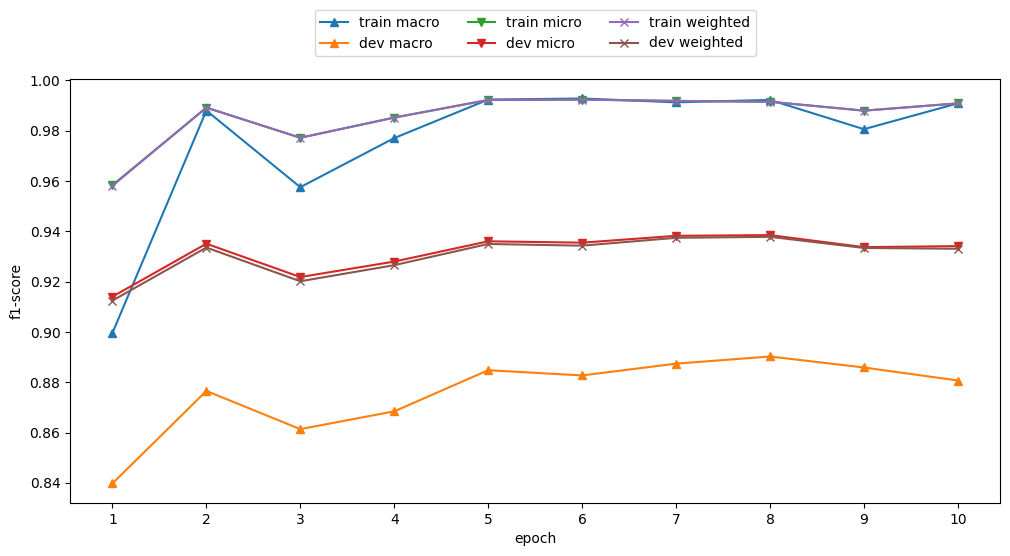

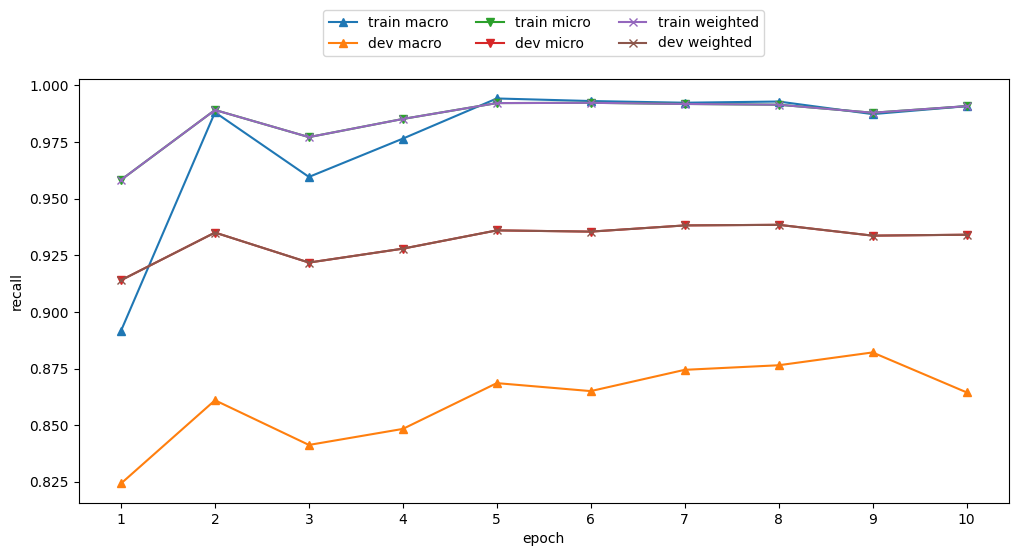

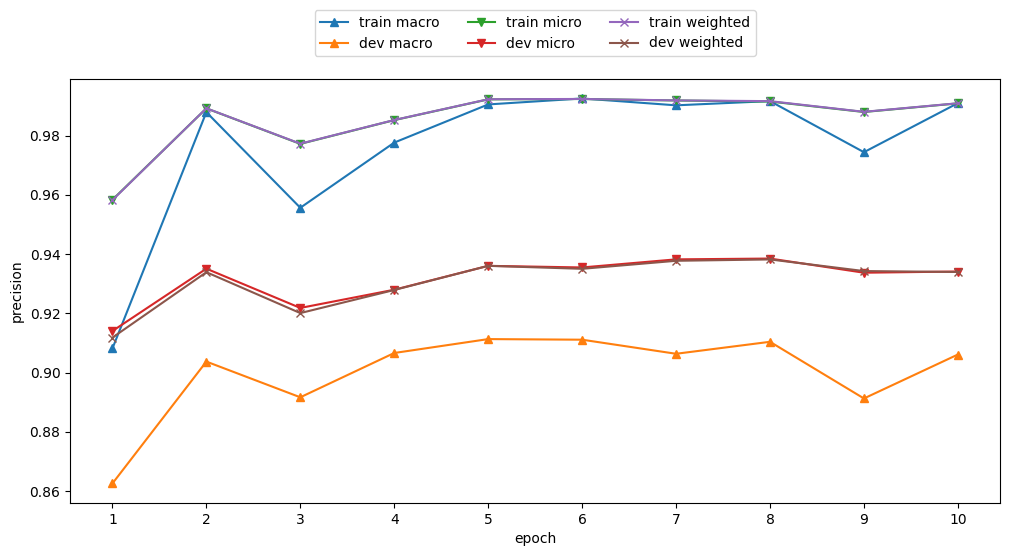

In [37]:
plot_loss_acc(data, indices, output_path, train_key)
plot_metric("accuracy")
plot_score_averages("f1-score")
plot_score_averages("recall")
plot_score_averages("precision")

/proj/berzelius-2021-21/users/jacob/conda_envs/nilsre/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


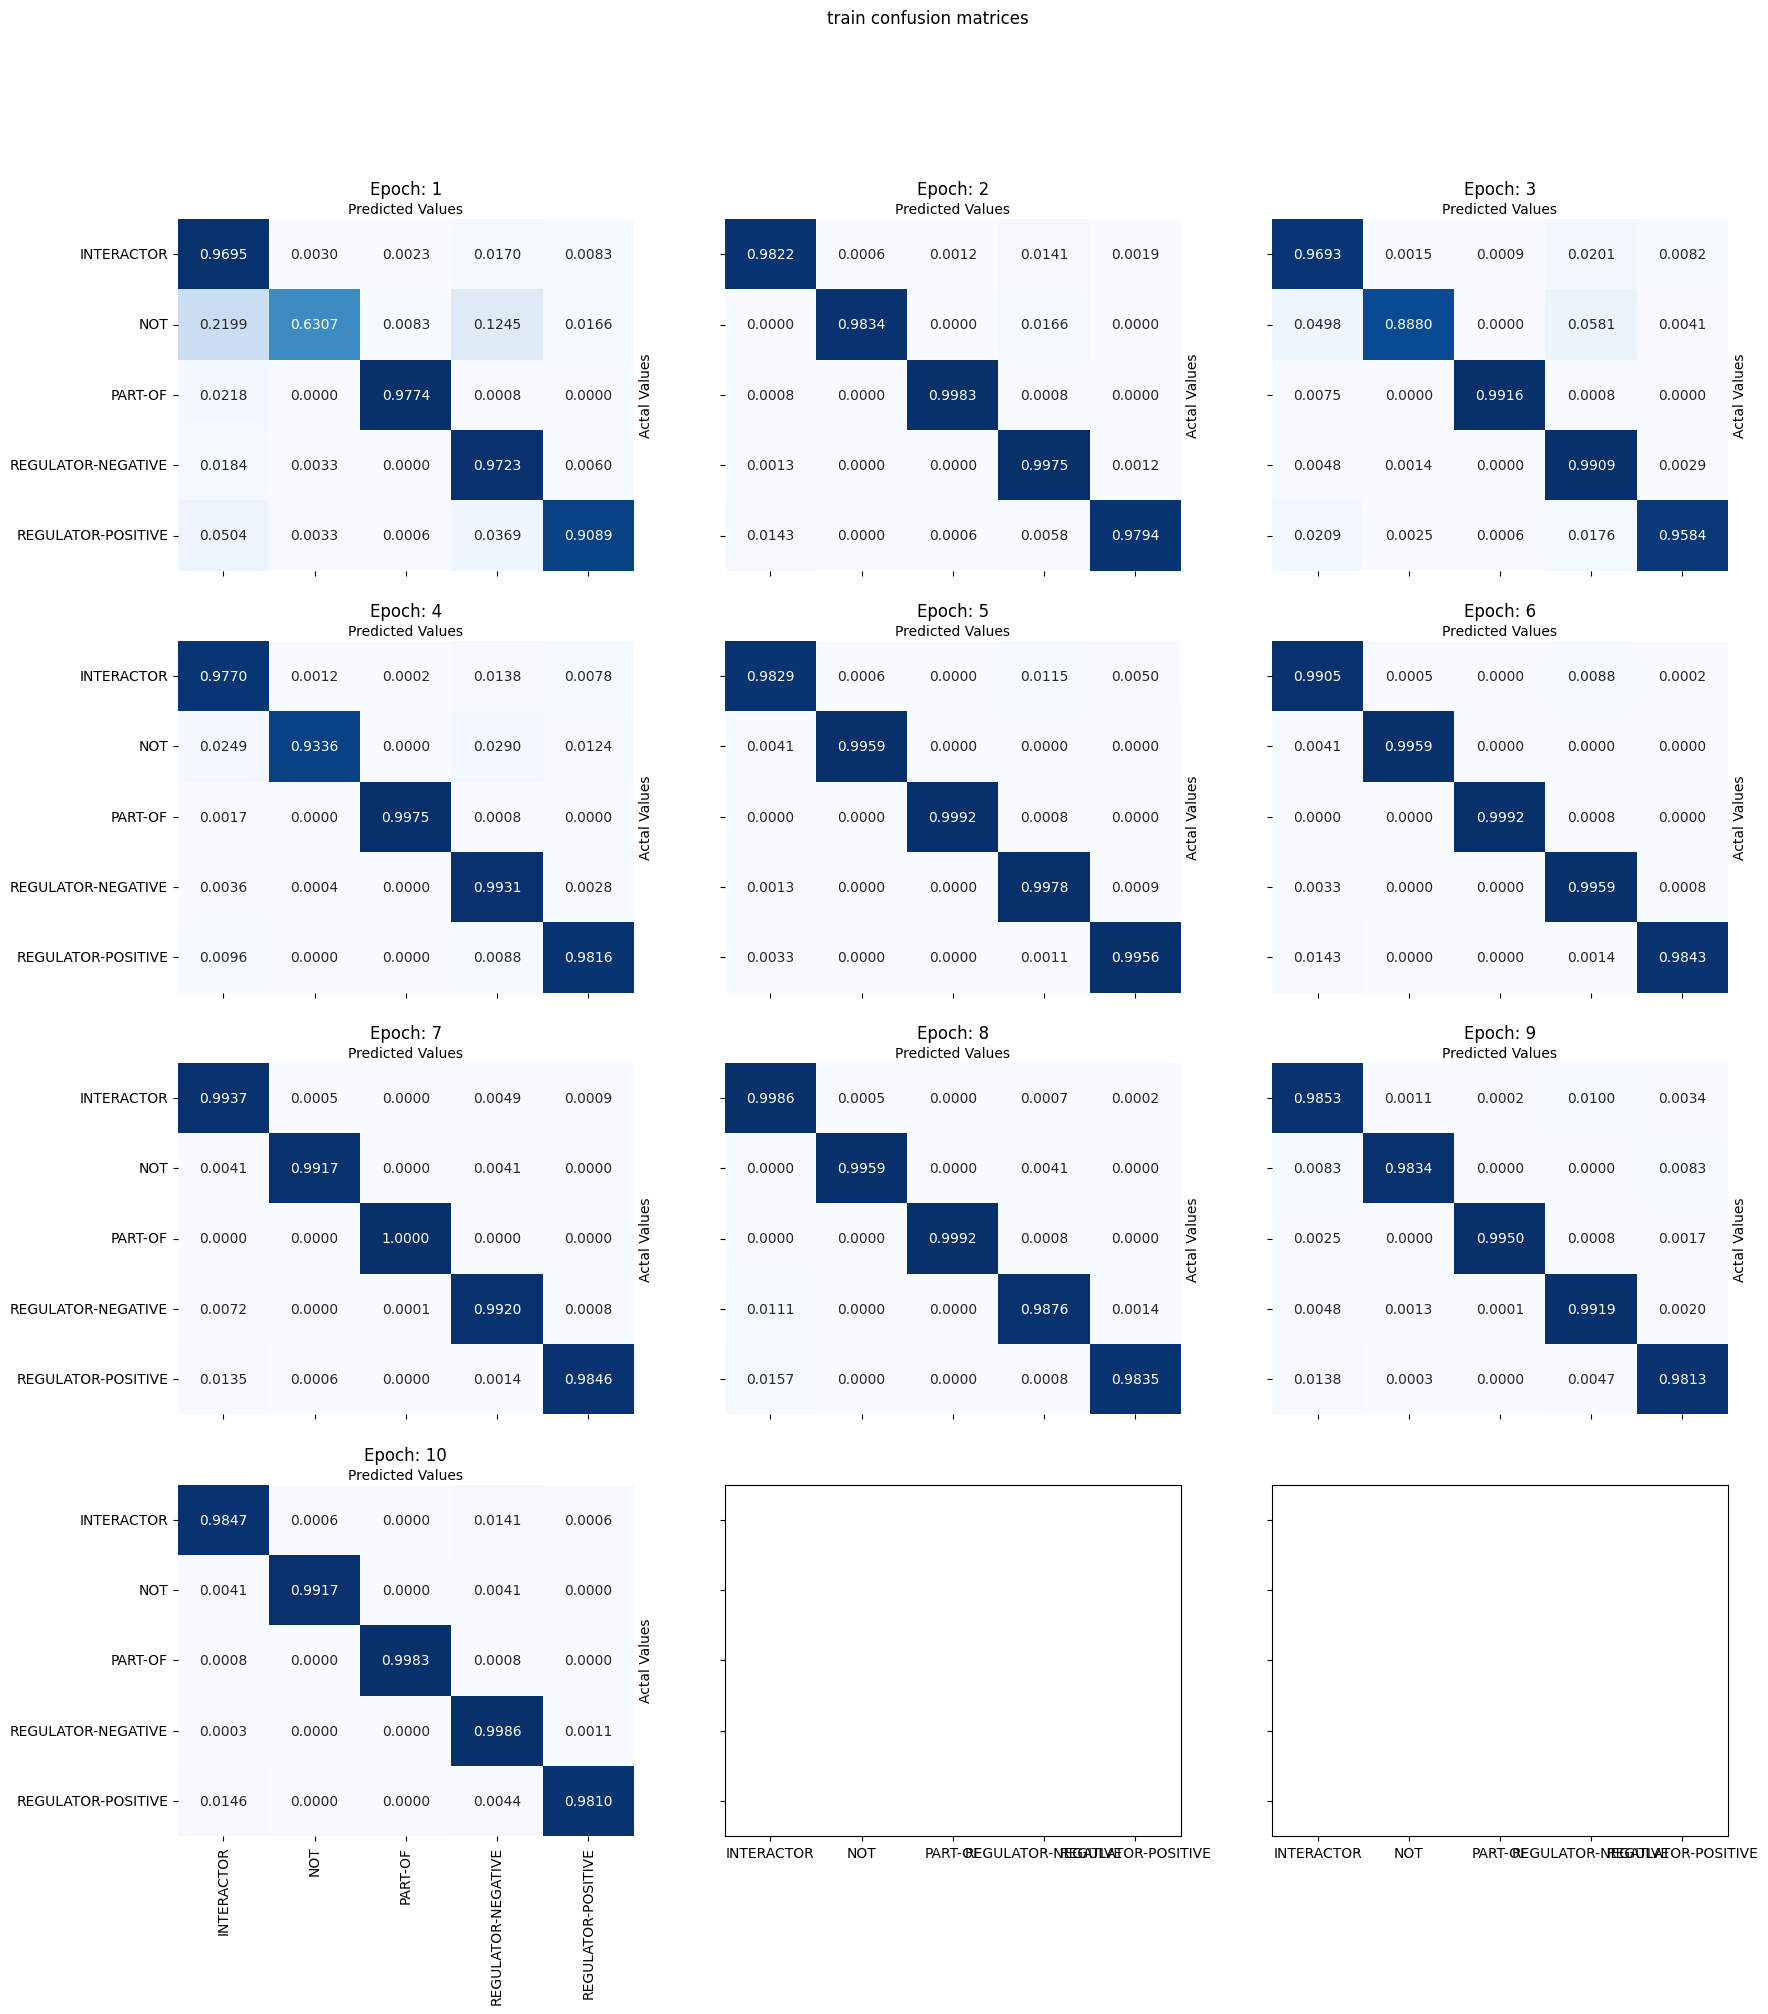

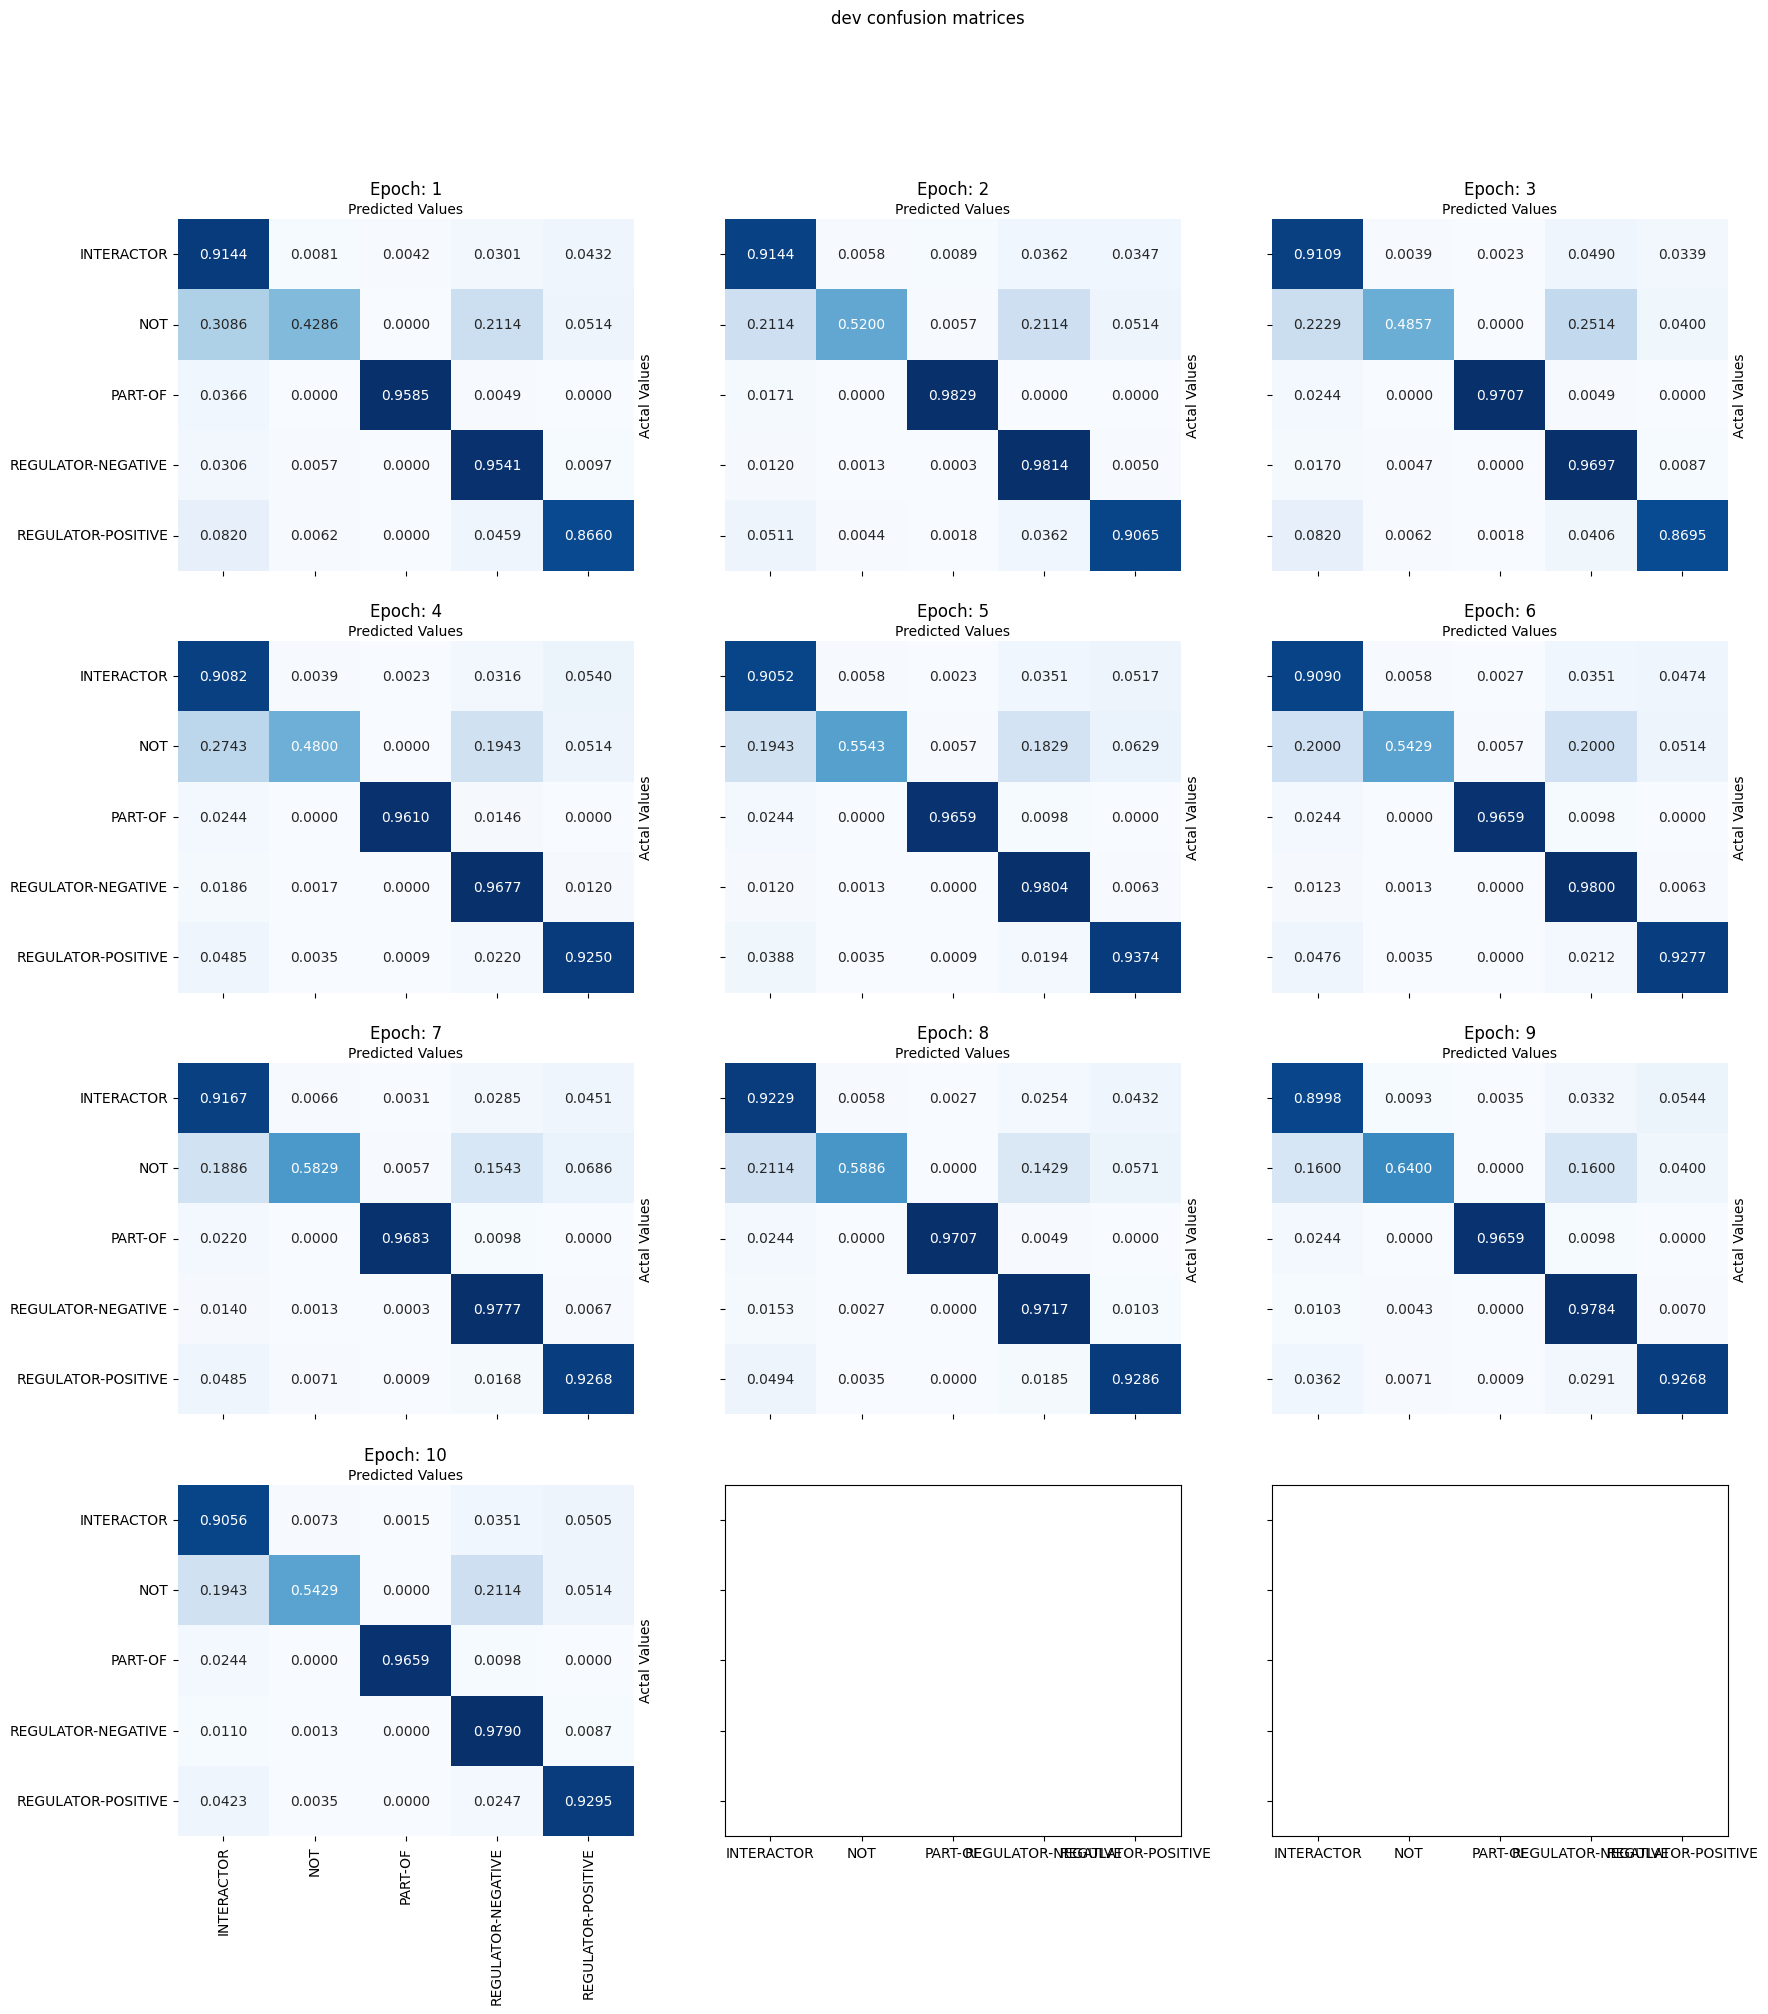

In [51]:
plot_confusion_matrices(train_data, "train", normalize=True)
plot_confusion_matrices(dev_data, "dev", normalize=True)

### Investigate gradients

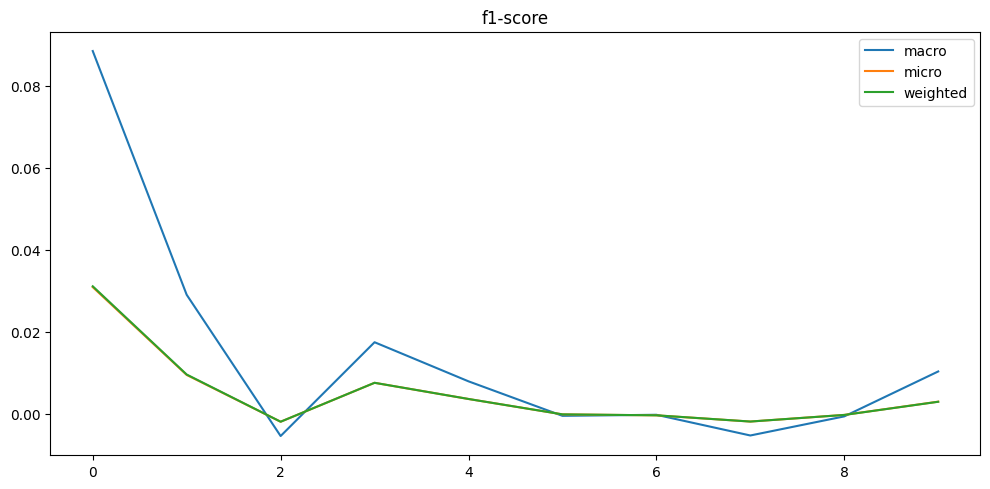

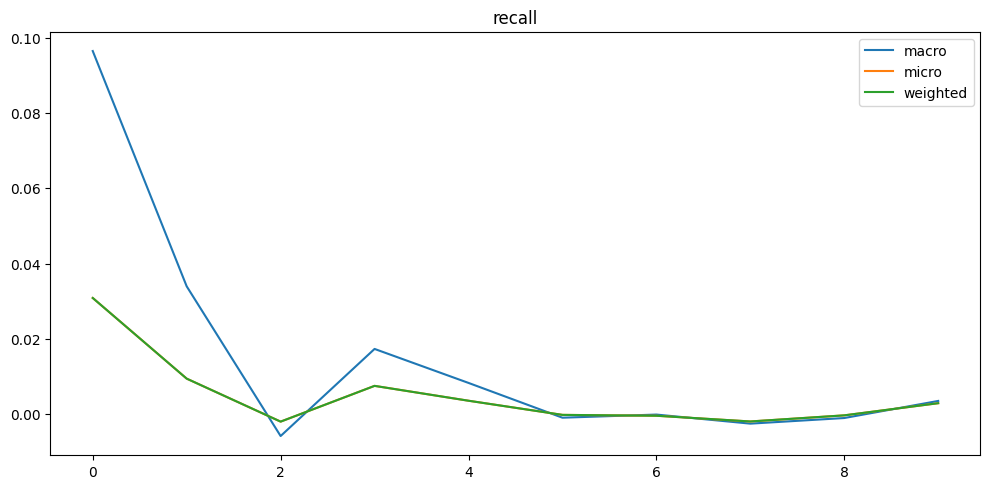

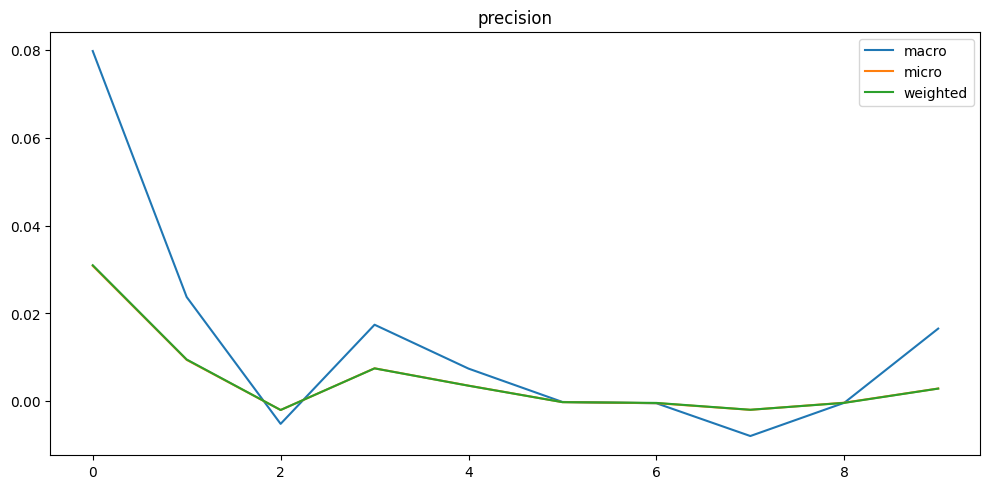

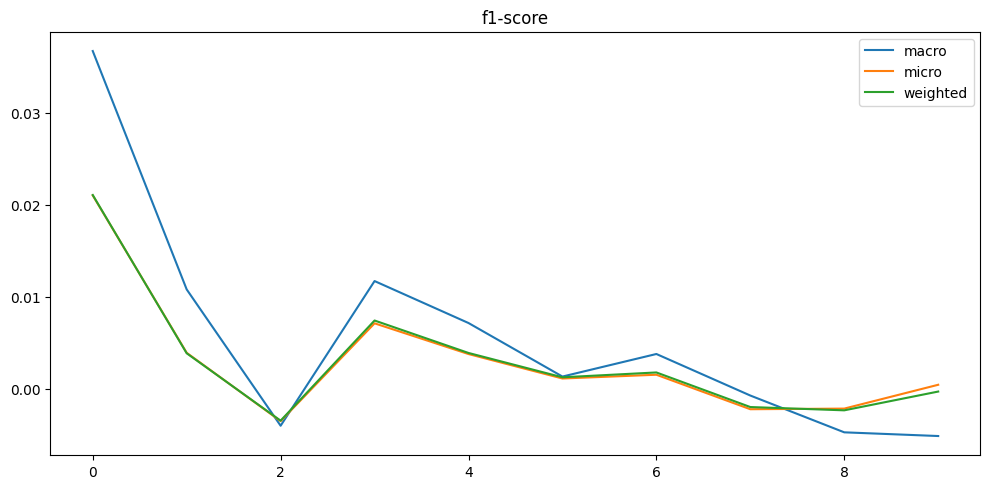

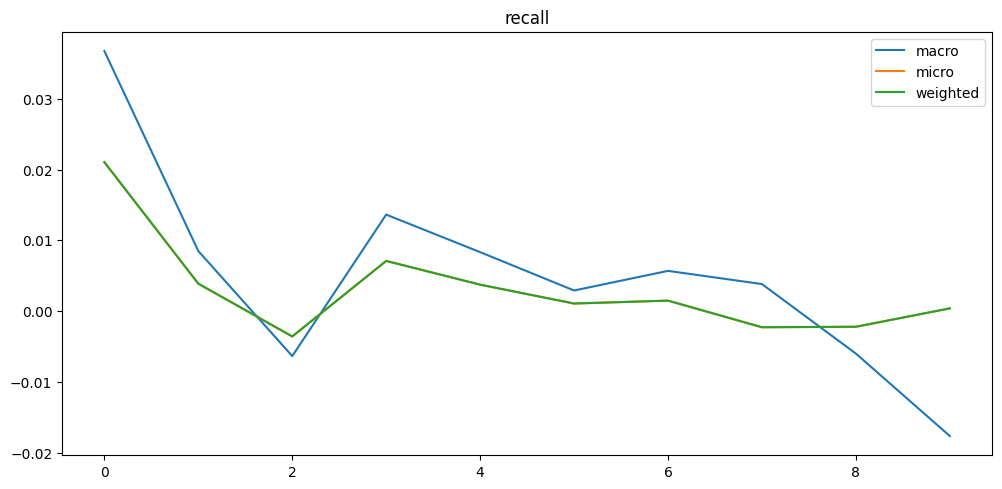

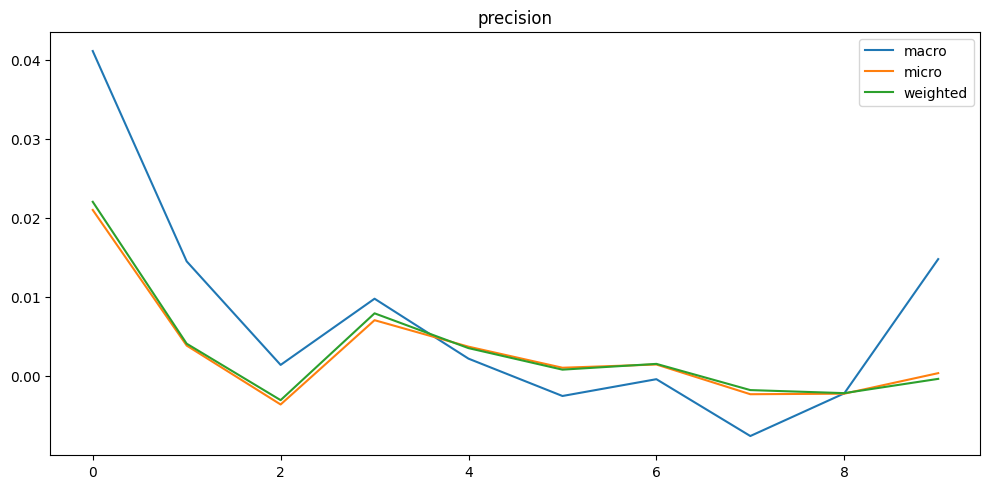

In [39]:
def plot_gradients(ds_evaluation):
    scores = ['f1-score', 'recall', 'precision']
    for score in scores:
        plt.figure()
        for avg_type in ds_evaluation[score]:
            test_lista = np.array(ds_evaluation[score][avg_type])
            plt.plot(range(len(test_lista)), np.gradient(test_lista))
        plt.title(score)
        plt.legend(['macro', 'micro', 'weighted'])


plot_gradients(train_data)
plot_gradients(dev_data)


### Best model score epochs

In [17]:
def print_best_scores(ds_evaluation, ds_name):
    scores = ['f1-score', 'recall', 'precision']
    print(f'{ds_name:^32}')
    for score in scores:
        print(f"\n{score+':':<12} {'score':^10} {'epochs':^10}")
        for avg_type in ds_evaluation[score]:
            score_list = ds_evaluation[score][avg_type]
            best_value = max(score_list)
            epochs = score_list.index(best_value)
            print(f"  {avg_type+':':<10} {best_value:>10.6f} {epochs:>10}")


In [18]:
print_best_scores(train_data, 'Train set')
print_best_scores(dev_data, 'Dev set')

           Train set            

f1-score:      score      epochs  
  macro:       0.995512          9
  micro:       0.995478          9
  weighted:    0.995478          9

recall:        score      epochs  
  macro:       0.996583          9
  micro:       0.995478          9
  weighted:    0.995478          9

precision:     score      epochs  
  macro:       0.994543          8
  micro:       0.995478          9
  weighted:    0.995484          9
            Dev set             

f1-score:      score      epochs  
  macro:       0.845590          9
  micro:       0.865579          7
  weighted:    0.864939          9

recall:        score      epochs  
  macro:       0.843978          9
  micro:       0.865579          7
  weighted:    0.865579          7

precision:     score      epochs  
  macro:       0.874938          2
  micro:       0.865579          7
  weighted:    0.864752          9


In [40]:
def print_best_scores(ds_evaluation, ds_name):
    scores = ['f1-score', 'recall', 'precision']
    print(f"{'':12}  {ds_name[0]:^20} {ds_name[1]:^20}")
    print(f"{'':12} {'score':^10} {'epochs':^10} {'score':^10} {'epochs':^10}")
    for score in scores:
        print(f"{score+':':<12}")
        for avg_type in ds_evaluation[0][score]:
            score_lists = [ds_evaluation[0][score][avg_type], ds_evaluation[1][score][avg_type]]
            best_value = [max(score_lists[0]), max(score_lists[1])]
            epochs = [score_lists[0].index(best_value[0]), score_lists[1].index(best_value[1])]
            print(f"  {avg_type+':':<10} {best_value[0]:^10.6f} {epochs[0]:^10} {best_value[1]:^10.6f} {epochs[1]:^10}")
        print('')


In [41]:
print_best_scores(ds_evaluation=[train_data, dev_data], ds_name=['Train set', 'Dev set'])

                   Train set             Dev set       
               score      epochs     score      epochs  
f1-score:   
  macro:      0.992824      5       0.890239      7     
  micro:      0.992362      5       0.938499      7     
  weighted:   0.992359      5       0.937814      7     

recall:     
  macro:      0.994272      4       0.882158      8     
  micro:      0.992362      5       0.938499      7     
  weighted:   0.992362      5       0.938499      7     

precision:  
  macro:      0.992538      5       0.911310      4     
  micro:      0.992362      5       0.938499      7     
  weighted:   0.992374      5       0.938199      7     



### Slicing

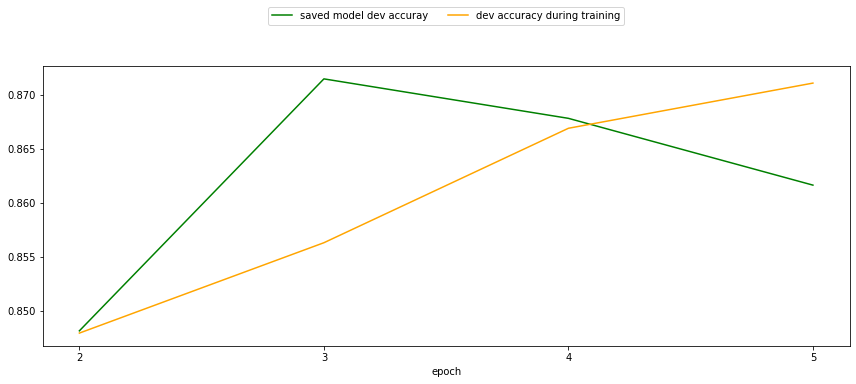

In [52]:
x = list(indices)

slce = 

plt.xticks(indices)

plt.plot(x[1:5], data[dev_key]['accuracy'][1:5],     color="green") # accuracies returned by the eval.py script
plt.plot(x[1:5], data['average validation accuracy'][1:5], color="orange")

plt.legend(["saved model dev accuray", 'dev accuracy during training'], 
            loc="upper center", bbox_to_anchor=(0.5, 1.23),
            fancybox=True, ncol=2)

plt.xlabel('epoch')
plt.tight_layout()
plt.show()